In [1]:
%matplotlib notebook

# Dependencies
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import sys
import pandas as pd

import colony_iomethods as cm
import tracker as tr

from matplotlib import pyplot as plt

In [78]:
# Folder for the files
exp_name = "EQ59_01072021_12am"
acq_name = "Interval12-36h_10pm"
# acq_name = "First12h"

# base_folder = f"C:/Users/Tolga/Dropbox/GitHub/colony-image-analysis/{exp_name}/{acq_name}/"
base_folder = f"D:/Tolga/Colony Images/{exp_name}/{acq_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

# Video folder
video_folder = base_folder + "Videos_Unmarked/"
# Data folder for analysis:
resource_folder = base_folder + "Resources/"
csv_path = resource_folder + f"{acq_name}_Movie.csv"

In [79]:
# Collect information from the xml
dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
xvoxel = dim_desc["xvoxel"]
yvoxel = dim_desc["yvoxel"]
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# Tilescan info
tilescan_desc = cm.collectTileScan(image_xml)
xixar = tilescan_desc["xix_unique_ar"]
yixar = tilescan_desc["yix_unique_ar"]

tilescan is set


## Important!! 
### Each frame is scaled from a tilescan of 1024x1024 images, to a final 512x512 in the video.
* Collect the tilescan positions and obtain the scalex and scaley

* Scale xvoxel and yvoxel accordingly


In [80]:
tilescan_desc = cm.collectTileScan(image_xml)

tile_xcnt = tilescan_desc["tile_xcnt"]
tile_ycnt = tilescan_desc["tile_ycnt"]

scalex = 1.0/tile_xcnt/2
scaley = 1.0/tile_ycnt/2

tilescan is set


## Collect image sequence from 512x512 videos

In [81]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, acq_name, t_str):
    # Run through a single timepoint
    video_path = video_folder + f"{acq_name}_{t_str}.avi"

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count))
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq

# frame info from test file

t_str = "t06"
video_path = video_folder + f"{acq_name}_{t_str}.avi"
vidcap = cv2.VideoCapture(video_path)

# Frame properties
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

## Interactive plot for locating center

<IPython.core.display.Javascript object>


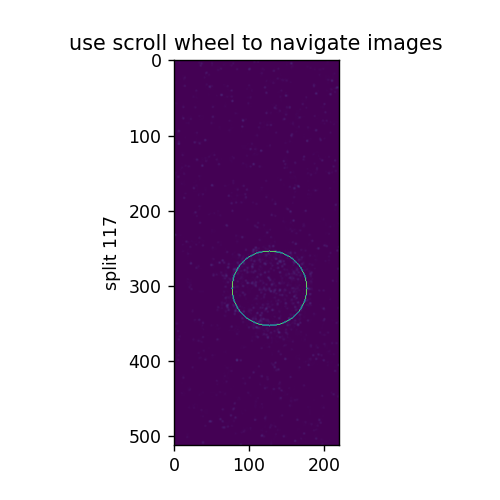

In [82]:
roi_width = 220
roi_height = frame_height
centerx = 126
centery = 303

idx = tuple(np.meshgrid(np.arange(0,roi_height), 
                        np.arange(0,roi_width)))


zar = np.arange(0,zsz)
img_seq = get_image_sequence(video_folder, acq_name, t_str)
img_seq_maxz = np.zeros((roi_height, roi_width, len(zar))) # numpy 3d array image sequence to track max intensity images
roi_image = np.zeros((roi_height, roi_width))
for zix in range(len(zar)):
    roi_image = img_seq[:,:,zix][idx]
    blurred_image = cv2.GaussianBlur(roi_image, (5,5), 0).astype(np.uint8)
    equalized_image = cv2.equalizeHist(blurred_image)
    ret, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
#     # Use threshold_image for manually measuring the radius and the center
#     img_seq_maxz[:, :, tix] = threshold_image
    # Use blurred_image for nice plots
    cv2.circle(blurred_image, (centery, centerx), 50, (255,255,255), 1)
    img_seq_maxz[:, :, zix] = blurred_image.transpose()
        

# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots(1, 1, figsize=(4,4))
tracker = tr.IndexTracker(ax, img_seq_maxz)#, args_dict)
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Check the block images through each z-stack
- tstr defined above

<IPython.core.display.Javascript object>


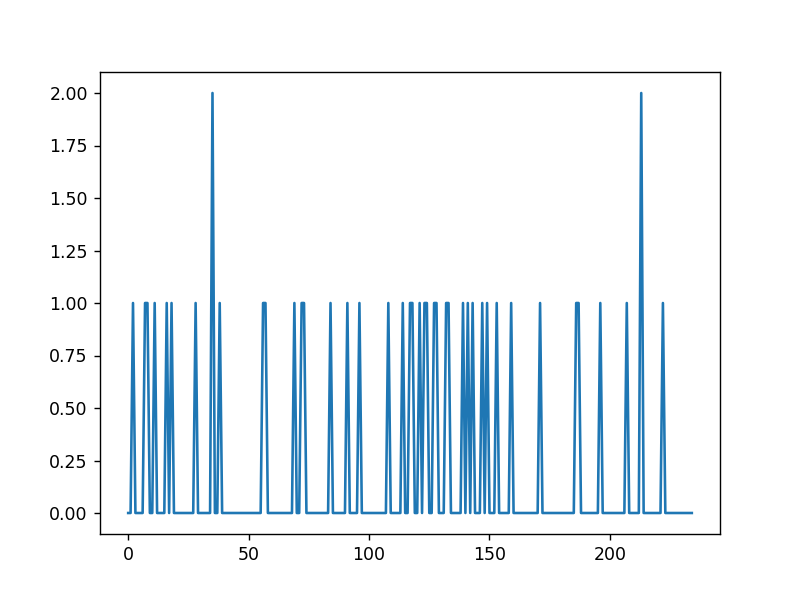

In [83]:
xix = 10
yix = 20
block_length = 5
block_zscan_cnt = np.zeros(frame_count)

for zix in range(frame_count):
    block_img = img_seq[yix:(yix+block_length),
                        xix:(xix+block_length),
                        zix]
#             block_zscan_mean[zix] = block_img.mean()
    block_zscan_cnt[zix] = (block_img > 30).sum()
fig,ax = plt.subplots(1,1)
ax.plot(zar, block_zscan_cnt)

## Block image - fine details
- tstr defined above

In [30]:
block_length = 5
pxl_threshold = 30

# block_zscan_mean = np.zeros((roi_height, roi_width, frame_count))
block_zscan_cnt = np.zeros((roi_height, roi_width, frame_count))
for yix in range(roi_height-block_length):
    print(yix, end='     \r', flush=True)
    for xix in range(roi_width-block_length):
        for zix in range(frame_count):
            block_img = img_seq[yix:(yix+block_length),
                                xix:(xix+block_length),
                                zix]
#             block_zscan_mean[yix, xix, zix] = block_img.mean()
            block_zscan_cnt[yix, xix, zix] = (block_img > pxl_threshold).sum()

## Calculate the height at each (x,y) point

<IPython.core.display.Javascript object>


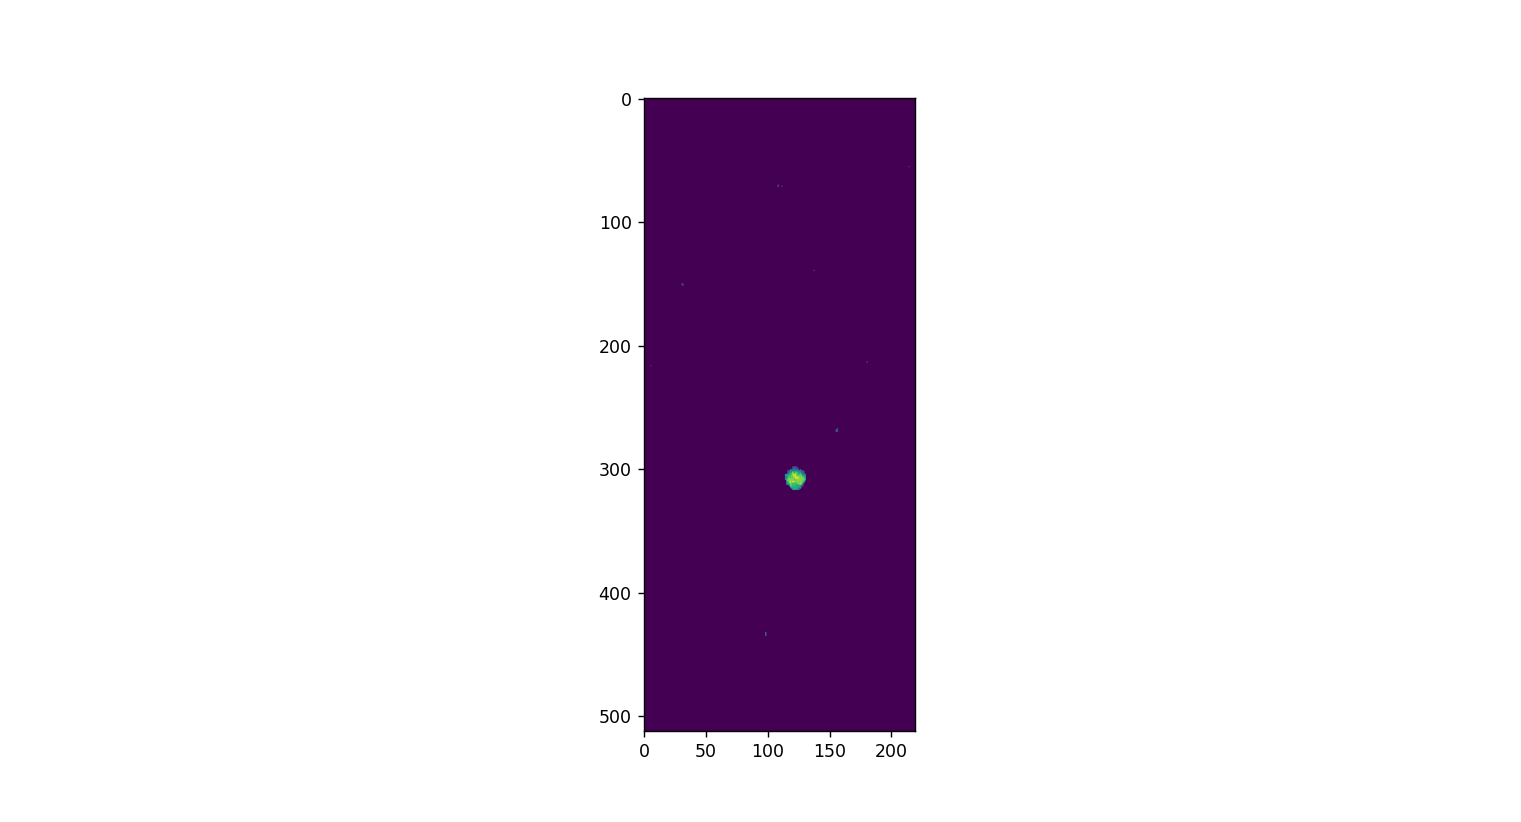

In [31]:
# For z-stack averaging the noisy data.
def window(size):
    return np.ones(size)/float(size)

window_average = 5
# yix = centery-20
# xix = centerx-30
# convolve

topval_img = np.zeros((roi_height, roi_width), dtype=np.uint8)
for yix in range(roi_height):
    for xix in range(roi_width):
        block_zscan = np.convolve(block_zscan_cnt[yix,xix,:], window(window_average), 'same')
        colony_exists = zar[(block_zscan > 2)]
        if len(colony_exists) > 0:
            topval_img[yix,xix] = colony_exists[-1]

fig,ax = plt.subplots(1,1)
# ax.plot(topval_img[:,centerx])
# ax.set_xlim(295,320)


# height_img.astype(np.uint8)
# cv2.imwrite(base_folder+"test.tif", height_img)
ax.imshow(topval_img)


## Calculate height for each time-frame and save to a tiff file file with uint8 code

In [84]:
# Calculate circular average
# LxL blocks
zar = np.arange(0,frame_count)
tar = np.arange(0,24)
# tar = np.array([7])
for tix in range(len(tar)):
    t_str = "t%02d" % tar[tix]
    print("\n" + t_str)
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
#     block_zscan_mean = np.zeros((roi_height, roi_width, frame_count))
    block_zscan_cnt = np.zeros((roi_height, roi_width, frame_count))
    topval_img = np.zeros((roi_height, roi_width), dtype=np.uint8)
    for yix in range(roi_height-block_length):
        print(yix, end='     \r', flush=True)
        for xix in range(roi_width-block_length):
            for zix in range(frame_count):
                block_img = img_seq[yix:(yix+block_length),
                                    xix:(xix+block_length),
                                    zix]
#                 block_zscan_mean[yix, xix, zix] = block_img.mean()
                block_zscan_cnt[yix, xix, zix] = (block_img > pxl_threshold).sum()
            block_zscan = np.convolve(block_zscan_cnt[yix,xix,:], window(window_average), 'same')
            colony_exists = zar[(block_zscan > 2)]
            if len(colony_exists) > 0:
                topval_img[yix,xix] = colony_exists[-1]
    
    cv2.imwrite(resource_folder + f"height_{t_str}.tif", topval_img)

        


t00
506                             
t01
506                    
t02
506                                   
t03
506              
t04
506                                       
t05
506                   
t06
506                        
t07
506     
t08
506                    
t09
506                       
t10
506                                       
t11
506                         
t12
506              
t13
506                         
t14
506                        
t15
506          
t16
506                                           
t17
506                        
t18
506               
t19
506                             
t20
506                              
t21
506     
t22
506                        
t23


## Find the surface from a block-image mean pixel values
- Using the left top corner

In [85]:
# Calculate background average, and find the bottom
corner_mean = np.zeros((len(zar), len(tar)))
zbottom = np.zeros(len(tar))
for tix in range(len(tar)):
    t_str = "t%02d" % tar[tix]
    print(t_str, end="   \r")
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
    for zix in range(len(zar)):
        corner_img = img_seq[:,:, zix]
        corner_mean[zix, tix] = corner_img.mean()
    corner_conv = np.convolve(corner_mean[:,tix], window(window_average), mode="same")
    zbottom[tix] = zar[np.argmax(corner_conv)]

## Calculate the height image
- top from the tif files, bottom from above

<IPython.core.display.Javascript object>


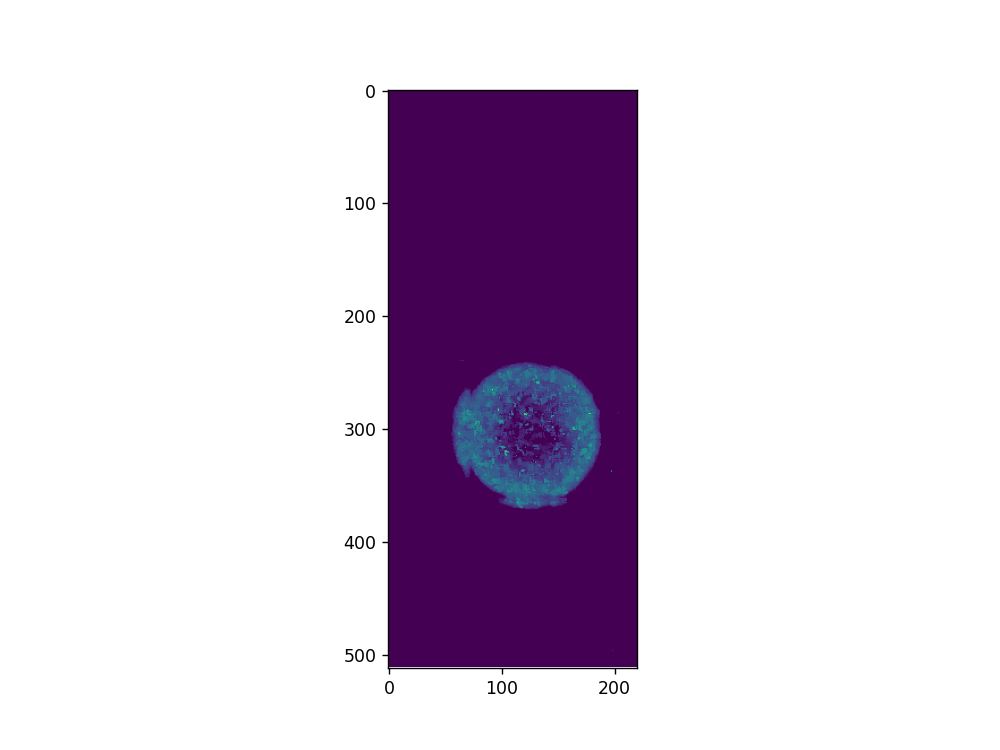

In [87]:
# for tix in range(len(tar)):
tix = 6
t_str = "t%02d" % tix
topval_img = cv2.imread(resource_folder + f"height_{t_str}.tif", cv2.IMREAD_GRAYSCALE)
height_img = topval_img - zbottom[tix]

# Set the negative values to zero
height_img[height_img < 0] = 0

fig, ax = plt.subplots(1,1)
ax.imshow(height_img)
# ax.plot(height_img[centery,:])
# ax.set_xlim(100,140)

### Reduced images from the frames of the videos

In [ ]:
# Calculate circular average
# LxL blocks
pxl_threshold = 10
cnt_threshold = 3
block_length = 5

reduced_height = int(roi_height/block_length)
reduced_width = int(roi_width/block_length)

zix = 3
print("\rCalculating %d/%d..." % (zix, frame_count), end="")
sys.stdout.flush()
reduced_avg_img = np.zeros((int(roi_height/block_length), 
                    int(roi_width/block_length)))
reduced_cnt_img = np.zeros((int(roi_height/block_length), 
                    int(roi_width/block_length)))
img_seq = get_image_sequence(video_folder, acq_name, "t12")
for yix in range(len(reduced_avg_img)):
    for xix in range(len(reduced_avg_img[yix])):
        block_img = img_seq[yix*block_length:(yix+1)*block_length,
                            xix*block_length:(xix+1)*block_length,
                            zix]
        reduced_avg_img[yix,xix] = block_img.mean()
        reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
    
fig,ax = plt.subplots(1,1)
ax.imshow(reduced_cnt_img > cnt_threshold)
# plt.hist(reduced_avg_img[reduced_avg_img > 10].flatten(), bins=100)
# ax.imshow(reduced_cnt_img > cnt_threshold)
# ax.imshow(cv2.GaussianBlur(reduced_cnt_img, (11,11), 0))

### Check the central_sum function for the given params

In [ ]:
img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
(reduced_height, reduced_width) = img.shape

Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

for Rix in range(len(Rar_pxl)):
    radius = Rar_pxl[Rix]

    circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
    cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)

    central_sum[Rix] = masked_data.sum()

# Calculate the uniform fit (polyfit with degree=0)
uniform_fit = np.zeros_like(Rar_pxl[:-1])
for ix in range(len(Rar_pxl[:-1])):
    edge_ix = Rar_pxl[ix]
    uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
    
fig,ax = plt.subplots(1,1)
ax.plot(Rar_pxl, central_sum)

edge_pxl = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
edge_pxl

### Central average throughout all scanning direcions (z and t)

In [ ]:
# Calculate circular average
# LxL blocks
zar = np.arange(0,frame_count)
tar = np.arange(0,12)
# tar = np.array([7])
outer_radius_ar = np.zeros((len(tar), len(zar)))
masked_mean = np.zeros_like(outer_radius_ar)
flip_masked_mean = np.zeros_like(outer_radius_ar)
unmasked_mean = np.zeros_like(outer_radius_ar)
for tix in range(len(tar)):
    t_str = "t%02d" % tar[tix]
    print("\n" + t_str)
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
    for zix in range(len(zar)):
        zstrix = zar[zix]
        z_str = "z%03d" % (zstrix)

        print("\rCalculating %d/%d for tix=%d/%d" % (zstrix, frame_count, tix, len(tar)), end="")
        sys.stdout.flush()

        reduced_avg_img = np.zeros((reduced_height, reduced_width))
        reduced_cnt_img = np.zeros_like(reduced_avg_img, dtype=np.int)

        for yix in range(len(reduced_avg_img)):
            for xix in range(len(reduced_avg_img[yix])):
                block_img = img_seq[yix*block_length:(yix+1)*block_length,
                                    xix*block_length:(xix+1)*block_length,
                                    zix]
                reduced_avg_img[yix,xix] = block_img.mean()
                reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()

        img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
        (reduced_height, reduced_width) = img.shape

        Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
        central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

        # Calculate central sum: the sum of intensity of each pixel inside a circle
        for Rix in range(len(Rar_pxl)):
            radius = Rar_pxl[Rix]

            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)

            central_sum[Rix] = masked_data.sum()


        # Calculate the uniform fit (polyfit with degree=0)
        uniform_fit = np.zeros_like(Rar_pxl[:-1])
        for ix in range(len(Rar_pxl[:-1])):
            edge_ix = Rar_pxl[ix]
            uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
        try:
            outer_radius_ar[tix, zix] = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
            radius = np.uint8(outer_radius_ar[tix,zix])
            
            full_img = img_seq[:,:,zix]
            full_circle_img = np.zeros((frame_height, frame_width), np.uint8)
            cv2.circle(full_circle_img, (centerx, centery), int(radius*block_length), 1, thickness=-1)
            
            masked_data = cv2.bitwise_and(full_img, full_img, mask=full_circle_img)
            flip_masked_data = cv2.bitwise_and(full_img, full_img, mask=(1-full_circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/full_circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-full_circle_img).sum()
            unmasked_mean[tix,zix] = full_img.mean()
        except IndexError:
            print("Index Error")
            outer_radius_ar[tix, zix] = 0
            radius = 0
            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius ,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)
            flip_masked_data = cv2.bitwise_and(img, img, mask=(1-circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-circle_img).sum()
            unmasked_mean[tix,zix] = img.mean()

In [ ]:
outer_radius_mm = xsz*tile_xcnt/reduced_height*xvoxel*outer_radius_ar/1e3
zar_mm = zar*zvoxel
df_dict = {"zar (mm)": zar_mm}
for tix in range(len(tar)):
    t_str = "t%02d" % (tix)
    df_dict[f"rad_{t_str} (mm)"] = outer_radius_mm[tix,:]
    df_dict[f"mean_{t_str}"] = unmasked_mean[tix,:]
    df_dict[f"col_mean_{t_str}"] = masked_mean[tix,:]
    df_dict[f"bg_mean_{t_str}"] = flip_masked_mean[tix,:]
    
df = pd.DataFrame(data = df_dict)
df.to_csv(csv_path)

df_metadata = pd.DataFrame({"type": "Movie",
                            "pxl_threshold": pxl_threshold,
                            "cnt_threshold": cnt_threshold,
                            "centerx": centerx,
                            "centery": centery,
                            "block_length": block_length,
                            "tsz": len(tar)},
                           index = [0])
df_metadata.to_csv(base_folder + f"Resources/{acq_name}_Movie_Metadata.csv")

In [ ]:
# df.plot(x="zar (mm)", y="bg_mean_t00")
fig,ax = plt.subplots(1,1)
# ax.plot(zar, outer_radius_mm[0,:])
ax.imshow(circle_img)

In [ ]:
print(outer_radius_ar.shape)
tar = np.arange(0,8)
height = np.zeros_like(tar)
for tix in range(len(tar)):
    height[tix] = (outer_radius_ar[tix,:]>2).sum()
    
t = tar/2 + 12
h = -height*zvoxel
fig,ax = plt.subplots(1,1, dpi=100)
ax.plot(t, h, 'o')
ax.set_xlim(10,30)
# ax.set_ylim(0,4)
ax.set_xlabel(r'Time after plating')
ax.set_ylabel(r'Colony height (um)')

p = np.polyfit(t[2:],h[2:],1)
tt = np.arange(0,30)
hh = p[0]*tt + p[1]
ax.plot(tt,hh, 'k--')
p

In [ ]:
df

In [ ]:
# df.plot(x="zar (mm)", y="bg_mean_t00")

fig,ax = plt.subplots(1,1)
zar = df["zar (mm)"]
ax.plot(zar, df["bg_mean_t00"],
       zar, df["bg_mean_t01"],
       zar, df["bg_mean_t02"],
       zar, df["bg_mean_t03"],
       zar, df["bg_mean_t04"],
       zar, df["bg_mean_t05"],
       zar, df["bg_mean_t06"],
       zar, df["bg_mean_t07"])

In [ ]:
flip_masked_mean.dtype

In [ ]:
df.plot(x="zar (mm)", y="col_mean_t01")